source: https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac#63b2
source: https://stackoverflow.com/questions/37228371/visualize-mnist-dataset-using-opencv-or-matplotlib-pyplot

color source: https://matplotlib.org/stable/tutorials/colors/colors.html
palette source: https://seaborn.pydata.org/tutorial/color_palettes.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

import random
import tqdm
import time

from permutation_testing import *
from model import *

plt.rcParams['patch.edgecolor'] = 'none' # remove edges from histogram bars

In [2]:
# setting random seed
# https://pytorch.org/docs/stable/notes/randomness.html 
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True

torch.backends.cudnn.benchmark = False 

In [3]:
%load_ext autoreload
%autoreload 2

torch.Size([256, 1, 28, 28])
Number of training samples: 60000
Number of test samples: 10000


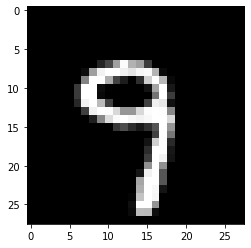

In [4]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)
batch_size = 256

train_data, val_data = random_split(train_dataset, [int(0.8 * m), int(0.2 * m)])
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False) # dangit

for data in train_loader:
    print(data[0].shape)
    break

plt.imshow(data[0][0].squeeze(), cmap='gray')

print('Number of training samples:', len(train_dataset))
print('Number of test samples:', len(test_dataset))

### keeping track of model weights
- 05232023a: epochs=50, lr=1e-3, d=4, inplace=T, ReLU
- 05302023a: epochs=50, lr=1e-3, d=4, inplace=F, ReLU 
- 05302023b: epochs=50, lr=1e-3, d=4, inplace=F, ELU 
- 06072023a: epochs=50, lr=1e-3, d=4, inplace=F, ELU; used deterministic things from PyTorch
    - epoch 50: train loss: 0.02580, val loss: 0.02636
- 06072023b: epochs=50, lr=1e-3, d=4, inplace=F, ELU; additionally used `torch.backends.cudnn.benchmark = False`
    - epoch 50: train loss: 0.02580, val loss: 0.02636
- 06072023c: same settings as 06072023b except d=6
    - epoch 50: train loss: 0.01868, val loss: 0.01931


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')  

loss_fn = torch.nn.MSELoss()
lr = 0.001
num_epochs = 50
d = 6

Selected device: cpu


In [6]:
%%time

train = False
version = '06072023c' # NOTE: MAKE SURE TO UPDATE THIS EVERY TIME

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

if train: 
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]

    optimizer = optim.Adam(params_to_optimize, lr=lr)
    print_every = 10

    encoder.to(device)
    decoder.to(device)
    plot_ae_outputs(encoder, decoder, test_dataset, device, n=10)
    losses = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        train_loss = train_epoch(encoder,decoder,device, train_loader,loss_fn, optimizer)
        val_loss = test_epoch(encoder, decoder, device, val_loader, loss_fn) # better for this to be val_loader?
        print('EPOCH {}/{}: train loss: {:.5f}, val loss: {:.5f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
        losses['train_loss'].append(train_loss)
        losses['val_loss'].append(val_loss)
        if (epoch + 1) % print_every == 0:
            plot_ae_outputs(encoder, decoder, test_dataset, device, n=10)
    # save the model
    torch.save(encoder.state_dict(), 'weights/encoder_weights_' + version + '.pth')
    torch.save(decoder.state_dict(), 'weights/decoder_weights_' + version + '.pth')
else:
    encoder.load_state_dict(torch.load('weights/encoder_weights_' + version + '.pth'))
    decoder.load_state_dict(torch.load('weights/decoder_weights_' + version + '.pth'))

encoder.eval(), decoder.eval()

CPU times: user 3.48 ms, sys: 1.69 ms, total: 5.17 ms
Wall time: 6.87 ms


(Encoder(
   (encoder_cnn): Sequential(
     (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ELU(alpha=1.0)
     (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (3): ELU(alpha=1.0)
     (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
     (5): ELU(alpha=1.0)
   )
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (encoder_lin): Sequential(
     (0): Linear(in_features=288, out_features=128, bias=True)
     (1): ELU(alpha=1.0)
     (2): Linear(in_features=128, out_features=6, bias=True)
   )
 ),
 Decoder(
   (decoder_lin): Sequential(
     (0): Linear(in_features=6, out_features=128, bias=True)
     (1): ELU(alpha=1.0)
     (2): Linear(in_features=128, out_features=288, bias=True)
     (3): ELU(alpha=1.0)
   )
   (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
   (decoder_conv): Sequential(
     (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
     (1): ELU(alpha=1.0)
     (2): ConvTranspose2d(16, 

In [7]:
test_error_on_classes = True
losses = {}
centers = {}
if test_error_on_classes:
    for label in data[1].unique():
        losses[label.item()] = 0
        centers[label.item()] = torch.zeros(6)
        num_digits = 0
        for ind, data in enumerate(test_loader):
            idx = data[1] == label.item()
            num_digits += idx.sum().item()
            original_images = data[0][idx]

            latent_representations = encoder(original_images)
            recon_images = decoder(latent_representations)

            losses[label.item()] += loss_fn(original_images, recon_images).item()
            centers[label.item()] += latent_representations.mean(dim=0)
        
        losses[label.item()] /= num_digits
        losses[label.item()] = np.round(losses[label.item()], 7)

        centers[label.item()] /= num_digits
    pd.Series(losses).sort_values()

In [10]:
pd.Series(losses).sort_values(ascending=False) # 8 has the greatest reconstruction error

8    0.001194
5    0.001158
2    0.001020
3    0.000971
6    0.000748
0    0.000733
4    0.000728
9    0.000646
7    0.000541
1    0.000144
dtype: float64

In [11]:
pairwise_center_distances = torch.zeros(10, 10)
for num1 in range(0, 10):
    for num2 in range(0, 10):
        pairwise_center_distances[num1, num2] = ((centers[num1] - centers[num2]) ** 2).sum()

In [12]:
# see which digits have closest embeddings on average
torch.topk(pairwise_center_distances, k=2, dim=1, largest=False) 
# so 8 and 3 are the digits with closest latent embeddings, on average

torch.return_types.topk(
values=tensor([[0.0000, 0.5765],
        [0.0000, 0.9230],
        [0.0000, 0.6556],
        [0.0000, 0.3532],
        [0.0000, 0.5178],
        [0.0000, 0.3877],
        [0.0000, 0.5765],
        [0.0000, 0.4212],
        [0.0000, 0.3532],
        [0.0000, 0.4212]], grad_fn=<TopkBackward0>),
indices=tensor([[0, 6],
        [1, 2],
        [2, 8],
        [3, 8],
        [4, 9],
        [5, 8],
        [6, 0],
        [7, 9],
        [8, 3],
        [9, 7]]))

## Convenience Functions

In [8]:
def p_val(simulated_stats, observed_stat):
    return (np.array([stat.item() for stat in simulated_stats]) > observed_stat.item()).mean()#i

In [9]:
def plot_permutation(
        simulated_stats, 
        observed_stat, 
        bins=50, 
        filepath='', 
        hist_color='tab:blue', 
        line_color='tab.red'
    ):
    print('p_value:', p_val(simulated_stats, observed_stat))
    sns.displot([mmd.item() for mmd in simulated_stats], bins=bins, color=hist_color)
    plt.axvline(observed_stat.item(), color=line_color)
    if filepath != '':
        print('Image saved to ' + str(filepath))
        plt.savefig(filepath + '.jpg', bbox_inches='tight')
    else:
        print('No image saved.')
    return

## Creating X and Y samples

### $X$ = {images of 8's}, $Y$ = {images of 3's}

In [46]:
# generate x_batch, y_batch
x_batch = []
y_batch = []
for ind, data in enumerate(test_loader): # filter batches based on digit
    if ind == 5: 
        r_batch = data[0][(data[1] == 8) | (data[1] == 3)]
    elif 5 < ind and ind < 15:
        x_batch.append(data[0][data[1] == 8])
        y_batch.append(data[0][data[1] == 3])
    elif ind == 15: 
        break
x_batch = torch.cat(x_batch, dim=0)
y_batch = torch.cat(y_batch, dim=0)
print('x_batch shape:', x_batch.shape)
print('y_batch shape:', y_batch.shape)
print('r_batch shape:', r_batch.shape)

n_perms = 250

x_batch shape: torch.Size([224, 1, 28, 28])
y_batch shape: torch.Size([237, 1, 28, 28])
r_batch shape: torch.Size([51, 1, 28, 28])


### Statistics for Anisotropic Kernel

100%|██████████| 250/250 [00:14<00:00, 17.14it/s]


bandwidth: 0.125
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_anisotropic_s-3_8v3


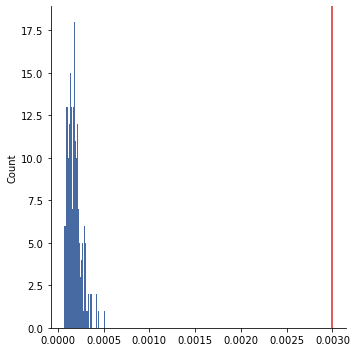

100%|██████████| 250/250 [00:16<00:00, 14.92it/s]


bandwidth: 0.25
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_anisotropic_s-2_8v3


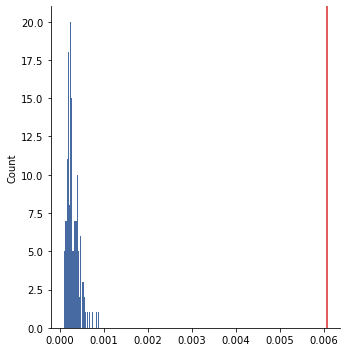

100%|██████████| 250/250 [00:13<00:00, 18.09it/s]


bandwidth: 0.5
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_anisotropic_s-1_8v3


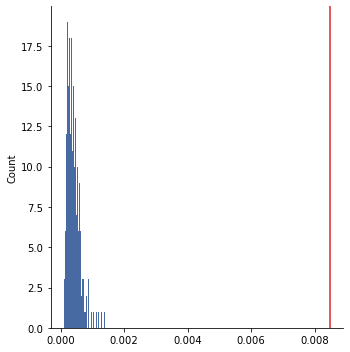

100%|██████████| 250/250 [00:14<00:00, 17.84it/s]


bandwidth: 1
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_anisotropic_s0_8v3


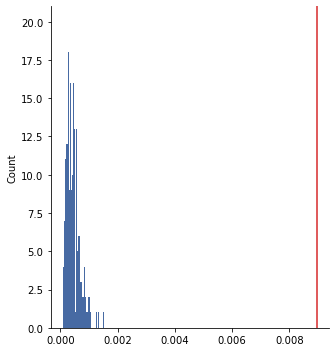

100%|██████████| 250/250 [00:14<00:00, 17.79it/s]


bandwidth: 2
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_anisotropic_s1_8v3


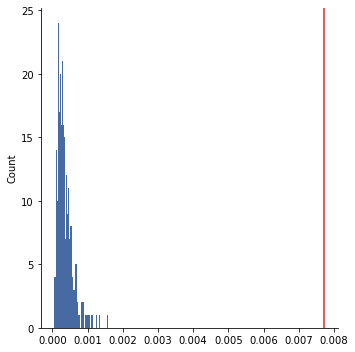

100%|██████████| 250/250 [00:14<00:00, 17.25it/s]


bandwidth: 4
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_anisotropic_s2_8v3


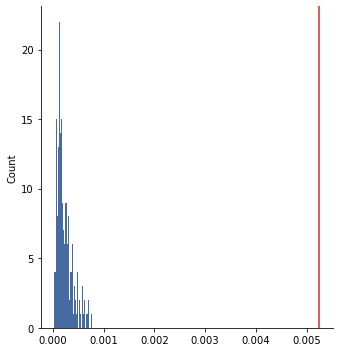

100%|██████████| 250/250 [00:13<00:00, 17.97it/s]


bandwidth: 8
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_anisotropic_s3_8v3


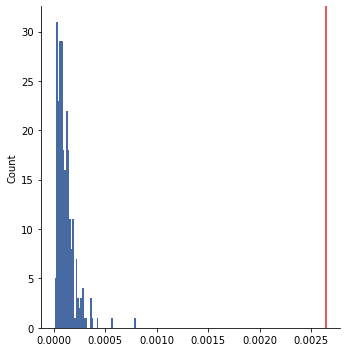

CPU times: user 2min 53s, sys: 6min 5s, total: 8min 58s
Wall time: 1min 55s


In [14]:
%%time

# anisotropic mmd

encoder.eval()
diff_anisotropic_stats = {}
for val in [-3, -2, -1, 0, 1, 2, 3]:
    start = time.time()
    observed_mmd_anisotropic8v3, simulated_mmds_anisotropic8v3 = permutation_test_anisotropic_mmd(
        x_batch, y_batch, r_batch, encoder, n_perms=n_perms, sigma_squared=(2 ** val)
    )
    end = time.time()
    p = p_val(simulated_mmds_anisotropic8v3, observed_mmd_anisotropic8v3)
    diff_anisotropic_stats[val] = {'p': p, 'time': end - start}

    hist_color = '#093885'
    line_color = 'tab:red'
    filepath = 'images_latentdim6_8v3v8/diff_anisotropic_s' + str(val) + '_8v3'

    print('bandwidth:', str(np.round(2 ** val, 3)))
    plot_permutation(
        simulated_mmds_anisotropic8v3, 
        observed_mmd_anisotropic8v3, 
        hist_color = hist_color, 
        line_color = line_color,
        filepath = filepath
    )
    plt.show()

In [15]:
diff_anisotropic_stats

{-3: {'p': 0.0, 'time': 16.131669998168945},
 -2: {'p': 0.0, 'time': 19.450505018234253},
 -1: {'p': 0.0, 'time': 16.172513961791992},
 0: {'p': 0.0, 'time': 15.594956159591675},
 1: {'p': 0.0, 'time': 15.692456007003784},
 2: {'p': 0.0, 'time': 15.834607124328613},
 3: {'p': 0.0, 'time': 15.415678024291992}}

### Statistics for Encoder Kernel

100%|██████████| 250/250 [00:26<00:00,  9.57it/s]

bandwidth: 0.125
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_encoder_s-3_8v3


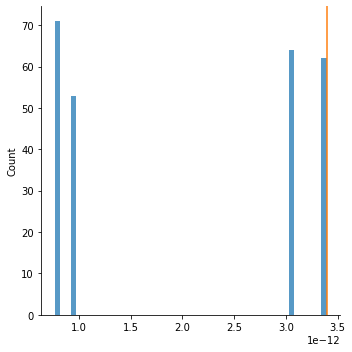

100%|██████████| 250/250 [00:26<00:00,  9.61it/s]


bandwidth: 0.25
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_encoder_s-2_8v3


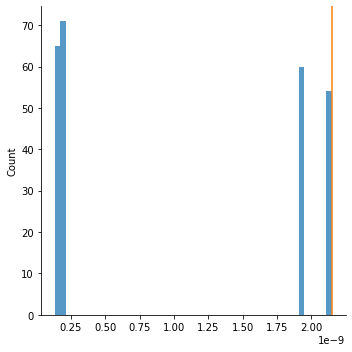

100%|██████████| 250/250 [00:25<00:00,  9.87it/s]


bandwidth: 0.5
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_encoder_s-1_8v3


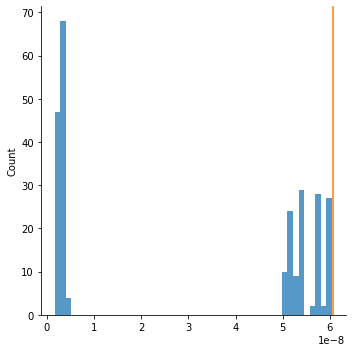

100%|██████████| 250/250 [00:25<00:00,  9.96it/s]


bandwidth: 1
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_encoder_s0_8v3


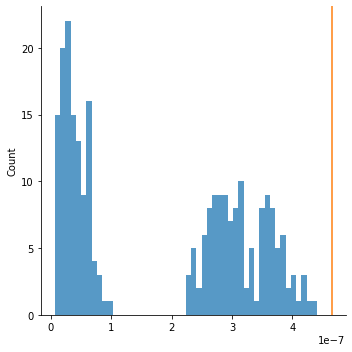

100%|██████████| 250/250 [00:25<00:00,  9.96it/s]


bandwidth: 2
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_encoder_s1_8v3


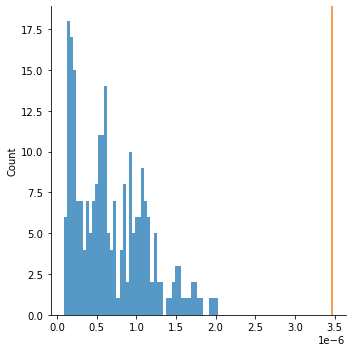

100%|██████████| 250/250 [00:26<00:00,  9.57it/s]


bandwidth: 4
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_encoder_s2_8v3


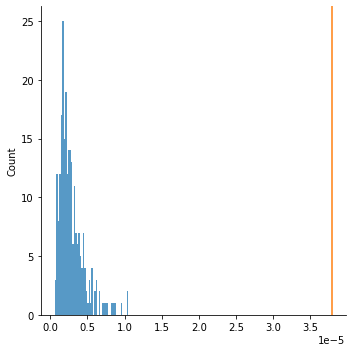

100%|██████████| 250/250 [00:25<00:00,  9.71it/s]


bandwidth: 8
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_encoder_s3_8v3


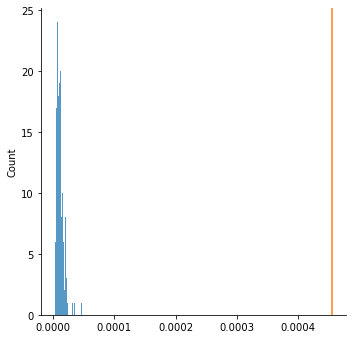

In [19]:
# encoder mmd
# suspect this is less robust to variance since this is not linear

encoder.eval()
diff_encoder_stats = {}
for val in [-3, -2, -1, 0, 1, 2, 3]:
    start = time.time()
    observed_mmd_encoder8v3, simulated_mmds_encoder8v3 = permutation_test_encoder_mmd(
        x_batch, y_batch, r_batch, encoder, n_perms=n_perms, sigma_squared=(2 ** val)
    )
    end = time.time()
    p = p_val(simulated_mmds_encoder8v3, observed_mmd_encoder8v3)
    diff_encoder_stats[val] = {'p': p, 'time': end - start}

    hist_color = 'tab:blue'
    line_color = 'tab:orange'
    filepath = 'images_latentdim6_8v3v8/diff_encoder_s' + str(val) + '_8v3'

    print('bandwidth:', str(np.round(2 ** val, 3)))
    plot_permutation(
        simulated_mmds_encoder8v3, 
        observed_mmd_encoder8v3, 
        hist_color = hist_color, 
        line_color = line_color,
        filepath = filepath
    )
    plt.show()

In [32]:
diff_encoder_stats

{-3: {'p': 0.0, 'time': 26.23369526863098},
 -2: {'p': 0.0, 'time': 29.212039947509766},
 -1: {'p': 0.0, 'time': 28.505435943603516},
 0: {'p': 0.0, 'time': 28.319178104400635},
 1: {'p': 0.0, 'time': 28.39599895477295},
 2: {'p': 0.0, 'time': 28.8230037689209},
 3: {'p': 0.0, 'time': 29.046234846115112}}

### Statistics for Gaussian MMD

In [21]:
# xy_batch = torch.cat([x_batch, y_batch], dim=0)
# xy_batch_sample_mean = xy_batch.squeeze().flatten(start_dim=1).mean(dim=0)
# xy_batch_sample_var = ((xy_batch.squeeze().flatten(start_dim=1) - xy_batch_sample_mean) ** 2).sum() 
# xy_batch_sample_var /= (len(xy_batch ) - 1)
# xy_batch_sample_var = xy_batch_sample_var.item()
# print('xy_batch sample variance:', xy_batch_sample_var)

num_features = 28 * 28
print('number of features:', num_features)

# scale_sigma_squared = 1 / (xy_batch_sample_var * num_features)
auto_sigma_squared = 1 / num_features
# print('bandwidth selected by sklearn\'s scale method:', scale_sigma_squared)
print('bandwidth selected by sklearn\'s auto method:', auto_sigma_squared)

number of features: 784
bandwidth selected by sklearn's auto method: 0.0012755102040816326


100%|██████████| 250/250 [00:05<00:00, 48.38it/s]


bandwidth: 1.0
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s2.8848260237648284e-05_8v3


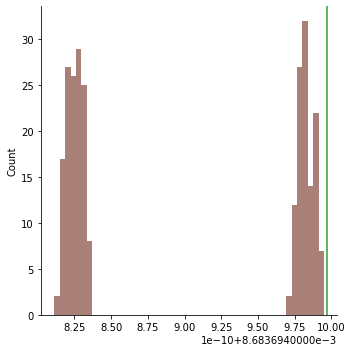

100%|██████████| 250/250 [00:03<00:00, 68.57it/s]


bandwidth: 1.001
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s0.0012755102040816326_8v3


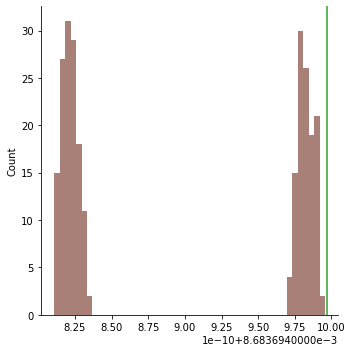

100%|██████████| 250/250 [00:03<00:00, 81.08it/s] 


bandwidth: 0.125
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s-3_8v3


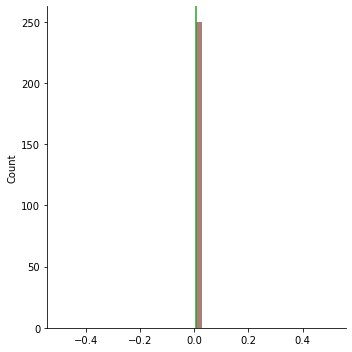

100%|██████████| 250/250 [00:02<00:00, 89.47it/s] 


bandwidth: 0.25
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s-2_8v3


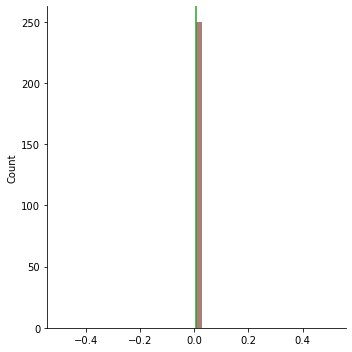

100%|██████████| 250/250 [00:03<00:00, 69.37it/s] 


bandwidth: 0.5
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s-1_8v3


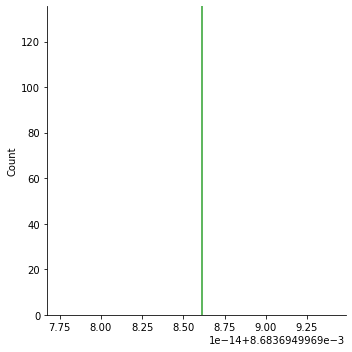

100%|██████████| 250/250 [00:03<00:00, 79.94it/s]


bandwidth: 1
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s0_8v3


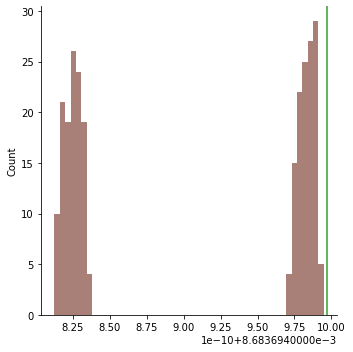

100%|██████████| 250/250 [00:02<00:00, 89.96it/s] 


bandwidth: 2
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s1_8v3


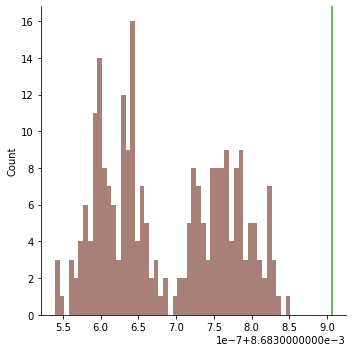

100%|██████████| 250/250 [00:03<00:00, 66.38it/s] 


bandwidth: 4
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s2_8v3


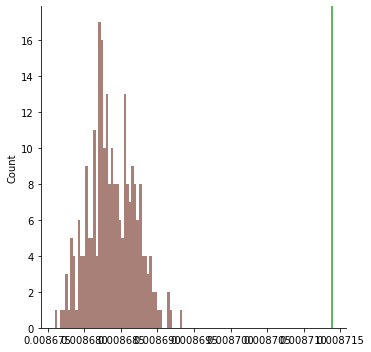

100%|██████████| 250/250 [00:03<00:00, 68.47it/s]


bandwidth: 8
p_value: 0.0
Image saved to images_latentdim6_8v3v8/diff_gaussian_s3_8v3


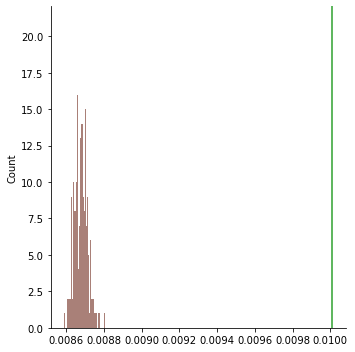

CPU times: user 2min 25s, sys: 59.6 s, total: 3min 25s
Wall time: 33 s


In [18]:
%%time

# gaussian mmd

diff_gaussian_stats = {}
for val in [scale_sigma_squared, auto_sigma_squared, -3, -2, -1, 0, 1, 2, 3]:
    start = time.time()
    observed_mmd_gaussian8v3, simulated_mmds_gaussian8v3 = permutation_test_gaussian_mmd(
        x_batch, y_batch, n_perms=n_perms, sigma_squared=(2 ** val)
    )
    end = time.time()
    p = p_val(simulated_mmds_gaussian8v3, observed_mmd_gaussian8v3)
    diff_gaussian_stats[val] = {'p': p, 'time': end - start}

    hist_color = 'tab:brown'
    line_color = 'tab:green'
    filepath = 'images_latentdim6_8v3v8/diff_gaussian_s' + str(val) + '_8v3'

    if val == scale_sigma_squared or val == auto_sigma_squared:
        print('bandwidth:', val)
    else:
        print('bandwidth:', str(np.round(2 ** val, 3)))
    plot_permutation(
        simulated_mmds_gaussian8v3, 
        observed_mmd_gaussian8v3, 
        hist_color = hist_color, 
        line_color = line_color,
        filepath = filepath
    )
    plt.show()

In [20]:
diff_gaussian_stats

{2.8848260237648284e-05: {'p': 0.0, 'time': 5.196414947509766},
 0.0012755102040816326: {'p': 0.0, 'time': 3.683488130569458},
 -3: {'p': 0.0, 'time': 3.092616319656372},
 -2: {'p': 0.0, 'time': 2.801586866378784},
 -1: {'p': 0.0, 'time': 3.6118781566619873},
 0: {'p': 0.0, 'time': 3.1359469890594482},
 1: {'p': 0.0, 'time': 2.788443088531494},
 2: {'p': 0.0, 'time': 3.7773919105529785},
 3: {'p': 0.0, 'time': 3.6625001430511475}}

### $X_1$ = {images of 8's}, $X_2$ = {images of 8's}

In [13]:
# testing when x1_batch and x2_batch are from the same distribution
x1_batch = []
x2_batch = []
r_batch = []
for ind, data in enumerate(test_loader): # filter batches based on digit
    if ind < 6:
        r_batch.append(data[0][data[1] == 8])
    elif 6 <= ind and ind % 2 == 0:
        x1_batch.append(data[0][data[1] == 8])
    elif 6 <= ind and ind % 2 == 1:
        x2_batch.append(data[0][data[1] == 8])
    if ind == 30: break
x1_batch = torch.cat(x1_batch, dim=0)
x2_batch = torch.cat(x2_batch, dim=0)
r_batch = torch.cat(r_batch, dim=0)
print('x1_batch shape:', x1_batch.shape)
print('x2_batch shape:', x2_batch.shape)
print('r_batch shape:', r_batch.shape)

n_perms = 250

x1_batch shape: torch.Size([347, 1, 28, 28])
x2_batch shape: torch.Size([289, 1, 28, 28])
r_batch shape: torch.Size([144, 1, 28, 28])


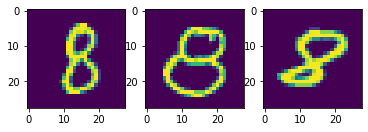

In [11]:
plt.subplot(1,3,1)
plt.imshow(x1_batch[0].squeeze())
plt.subplot(1,3,2)
plt.imshow(x2_batch[0].squeeze())
plt.subplot(1,3,3)
plt.imshow(r_batch[0].squeeze())

### Statistics for Anisotropic Kernel

100%|██████████| 250/250 [00:34<00:00,  7.20it/s]


bandwidth: 0.125
p_value: 0.26
Image saved to images_latentdim6_8v3v8/same_anisotropic_s-3_8v8


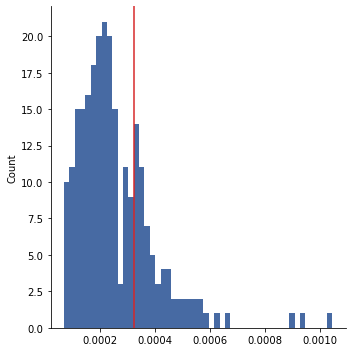

100%|██████████| 250/250 [00:33<00:00,  7.49it/s]


bandwidth: 0.25
p_value: 0.168
Image saved to images_latentdim6_8v3v8/same_anisotropic_s-2_8v8


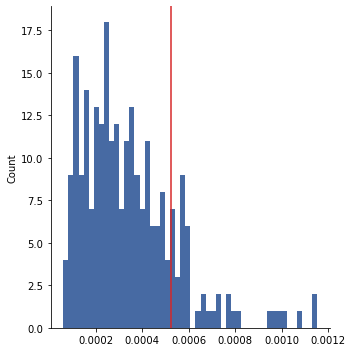

100%|██████████| 250/250 [00:35<00:00,  7.12it/s]


bandwidth: 0.5
p_value: 0.104
Image saved to images_latentdim6_8v3v8/same_anisotropic_s-1_8v8


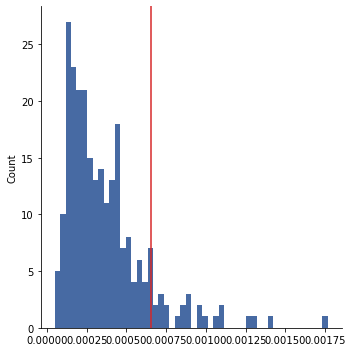

100%|██████████| 250/250 [00:33<00:00,  7.42it/s]


bandwidth: 1
p_value: 0.064
Image saved to images_latentdim6_8v3v8/same_anisotropic_s0_8v8


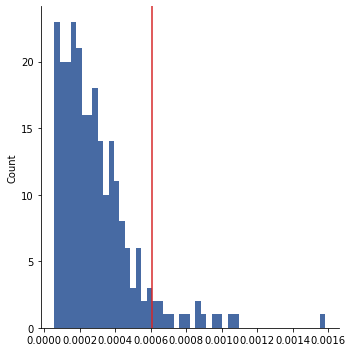

100%|██████████| 250/250 [00:36<00:00,  6.93it/s]


bandwidth: 2
p_value: 0.12
Image saved to images_latentdim6_8v3v8/same_anisotropic_s1_8v8


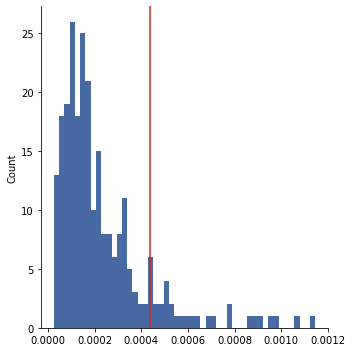

100%|██████████| 250/250 [00:33<00:00,  7.37it/s]


bandwidth: 4
p_value: 0.108
Image saved to images_latentdim6_8v3v8/same_anisotropic_s2_8v8


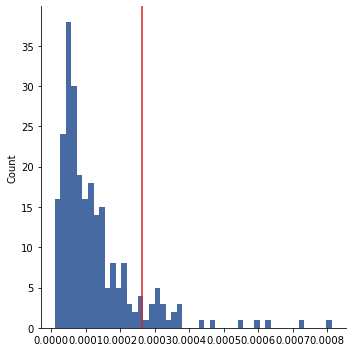

100%|██████████| 250/250 [00:33<00:00,  7.50it/s]


bandwidth: 8
p_value: 0.1
Image saved to images_latentdim6_8v3v8/same_anisotropic_s3_8v8


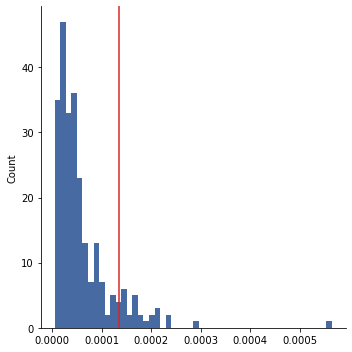

CPU times: user 9min 56s, sys: 15min 19s, total: 25min 16s
Wall time: 5min 1s


In [14]:
%%time

# anisotropic mmd
same_anisotropic_stats = {}
for val in [-3, -2, -1, 0, 1, 2, 3]:
    start = time.time()
    observed_mmd_anisotropic8v8, simulated_mmds_anisotropic8v8 = permutation_test_anisotropic_mmd(
        x1_batch, x2_batch, r_batch, encoder, n_perms=n_perms, sigma_squared = (2 ** val)
    )
    end = time.time()
    p = p_val(simulated_mmds_anisotropic8v8, observed_mmd_anisotropic8v8)
    same_anisotropic_stats[val] = {'p': p, 'time': end - start}

    hist_color = '#093885'
    line_color = 'tab:red'
    filepath = 'images_latentdim6_8v3v8/same_anisotropic_s' + str(val) + '_8v8'

    print('bandwidth:', str(np.round(2 ** val, 3)))
    plot_permutation(
        simulated_mmds_anisotropic8v8, 
        observed_mmd_anisotropic8v8, 
        hist_color = hist_color, 
        line_color = line_color,
        filepath = filepath
    )
    plt.show()

In [15]:
same_anisotropic_stats

{-3: {'p': 0.26, 'time': 42.830442905426025},
 -2: {'p': 0.168, 'time': 43.50366282463074},
 -1: {'p': 0.104, 'time': 44.080721855163574},
 0: {'p': 0.064, 'time': 41.48620295524597},
 1: {'p': 0.12, 'time': 44.44176387786865},
 2: {'p': 0.108, 'time': 42.545814037323},
 3: {'p': 0.1, 'time': 41.43160820007324}}

### Statistics for Encoder Kernel

100%|██████████| 250/250 [00:41<00:00,  6.02it/s]


bandwidth: 0.125
p_value: 0.564
Image saved to images_latentdim6_8v3v8/same_encoder_s-3_8v8


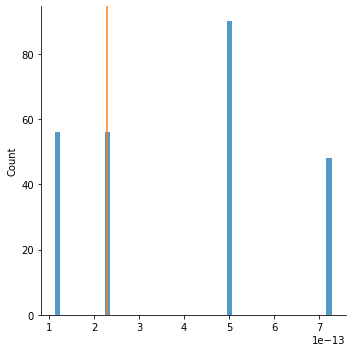

100%|██████████| 250/250 [00:42<00:00,  5.90it/s]


bandwidth: 0.25
p_value: 0.528
Image saved to images_latentdim6_8v3v8/same_encoder_s-2_8v8


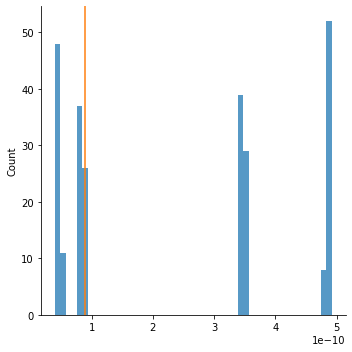

100%|██████████| 250/250 [00:43<00:00,  5.69it/s]


bandwidth: 0.5
p_value: 0.512
Image saved to images_latentdim6_8v3v8/same_encoder_s-1_8v8


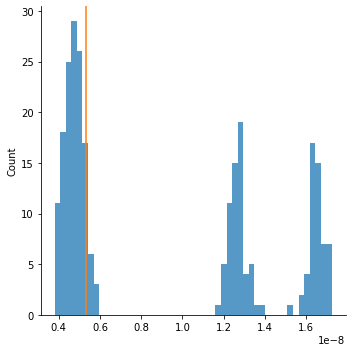

100%|██████████| 250/250 [00:44<00:00,  5.60it/s]


bandwidth: 1
p_value: 0.776
Image saved to images_latentdim6_8v3v8/same_encoder_s0_8v8


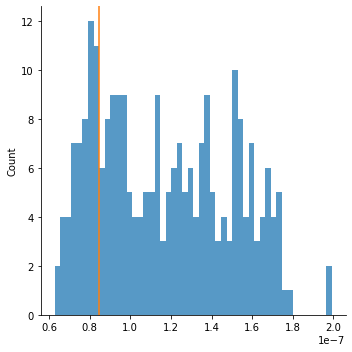

100%|██████████| 250/250 [00:45<00:00,  5.48it/s]


bandwidth: 2
p_value: 0.868
Image saved to images_latentdim6_8v3v8/same_encoder_s1_8v8


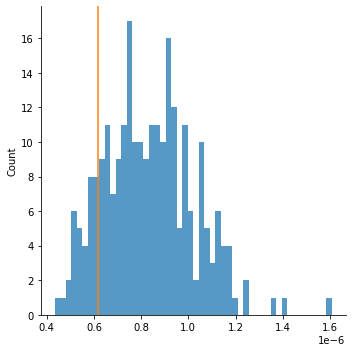

100%|██████████| 250/250 [00:48<00:00,  5.17it/s]


bandwidth: 4
p_value: 0.492
Image saved to images_latentdim6_8v3v8/same_encoder_s2_8v8


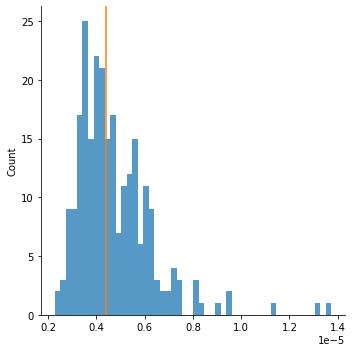

100%|██████████| 250/250 [00:45<00:00,  5.53it/s]


bandwidth: 8
p_value: 0.196
Image saved to images_latentdim6_8v3v8/same_encoder_s3_8v8


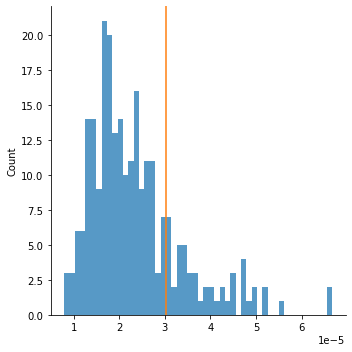

CPU times: user 6min 39s, sys: 17min 16s, total: 23min 55s
Wall time: 6min 22s


In [16]:
%%time

encoder.eval()
same_encoder_stats = {}
for val in [-3, -2, -1, 0, 1, 2, 3]:
    start = time.time()
    observed_mmd_encoder8v8, simulated_mmds_encoder8v8 = permutation_test_encoder_mmd(
        x1_batch, x2_batch, r_batch, encoder, n_perms=n_perms, sigma_squared=(2 ** val)
    )
    end = time.time()
    p = p_val(simulated_mmds_encoder8v8, observed_mmd_encoder8v8)
    same_encoder_stats[val] = {'p': p, 'time': end - start}

    hist_color = 'tab:blue'
    line_color = 'tab:orange'
    filepath = 'images_latentdim6_8v3v8/same_encoder_s' + str(val) + '_8v8'

    print('bandwidth:', str(np.round(2 ** val, 3)))
    plot_permutation(
        simulated_mmds_encoder8v8, 
        observed_mmd_encoder8v8, 
        hist_color = hist_color, 
        line_color = line_color,
        filepath = filepath
    )
    plt.show()

In [17]:
same_encoder_stats

{-3: {'p': 0.564, 'time': 41.78019309043884},
 -2: {'p': 0.528, 'time': 55.13121724128723},
 -1: {'p': 0.512, 'time': 55.01797914505005},
 0: {'p': 0.776, 'time': 55.86070704460144},
 1: {'p': 0.868, 'time': 58.68597722053528},
 2: {'p': 0.492, 'time': 58.95929002761841},
 3: {'p': 0.196, 'time': 55.95197892189026}}

### Statistics for Gaussian Kernel

100%|██████████| 250/250 [00:04<00:00, 51.22it/s]


bandwidth: auto
p_value: 0.356
Image saved to images_latentdim6_8v3v8/same_gaussian_sauto_8v8


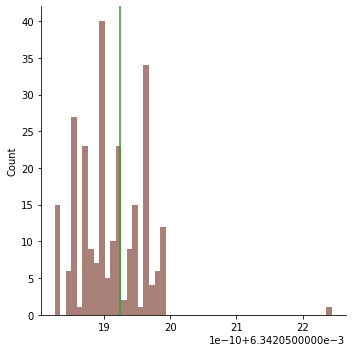

100%|██████████| 250/250 [00:04<00:00, 50.21it/s]


bandwidth: 0.125
p_value: 0.0
Image saved to images_latentdim6_8v3v8/same_gaussian_s-3_8v8


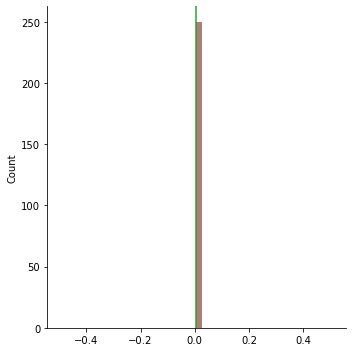

100%|██████████| 250/250 [00:04<00:00, 55.34it/s]


bandwidth: 0.25
p_value: 0.0
Image saved to images_latentdim6_8v3v8/same_gaussian_s-2_8v8


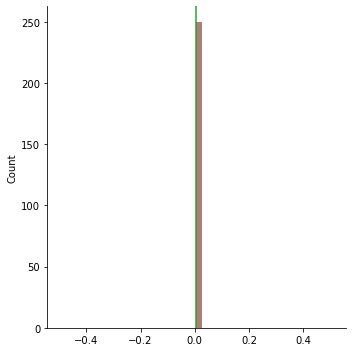

100%|██████████| 250/250 [00:05<00:00, 48.47it/s]


bandwidth: 0.5
p_value: 0.3
Image saved to images_latentdim6_8v3v8/same_gaussian_s-1_8v8


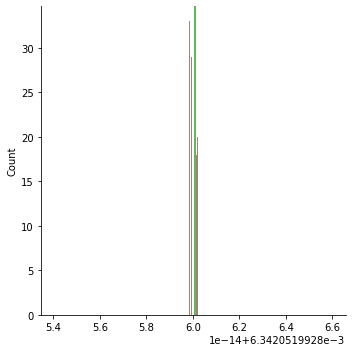

100%|██████████| 250/250 [00:04<00:00, 51.27it/s]


bandwidth: 1
p_value: 0.352
Image saved to images_latentdim6_8v3v8/same_gaussian_s0_8v8


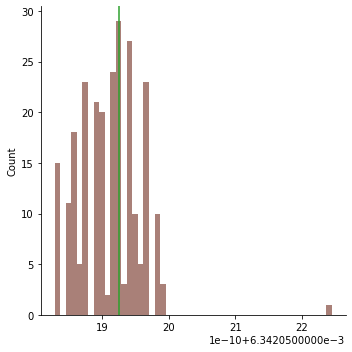

100%|██████████| 250/250 [00:04<00:00, 52.99it/s]


bandwidth: 2
p_value: 0.224
Image saved to images_latentdim6_8v3v8/same_gaussian_s1_8v8


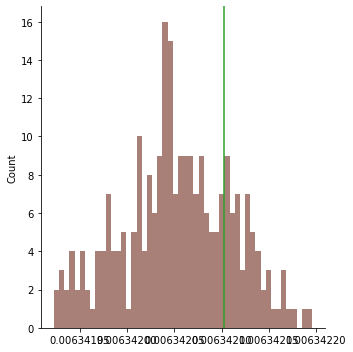

100%|██████████| 250/250 [00:04<00:00, 51.87it/s]


bandwidth: 4
p_value: 0.004
Image saved to images_latentdim6_8v3v8/same_gaussian_s2_8v8


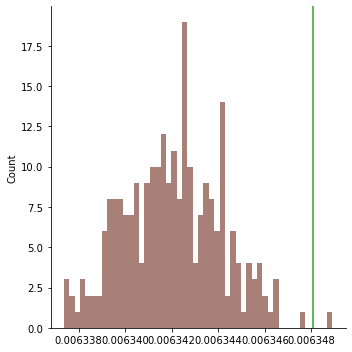

100%|██████████| 250/250 [00:04<00:00, 55.61it/s]


bandwidth: 8
p_value: 0.0
Image saved to images_latentdim6_8v3v8/same_gaussian_s3_8v8


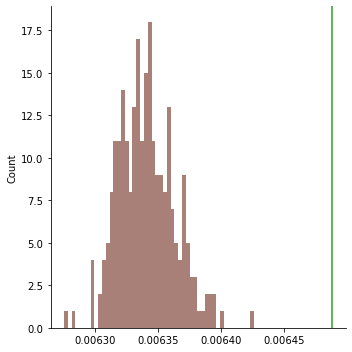

In [23]:
# gaussian mmd

same_gaussian_stats = {}
for val in [auto_sigma_squared, -3, -2, -1, 0, 1, 2, 3]:
    start = time.time()
    observed_mmd_gaussian8v8, simulated_mmds_gaussian8v8 = permutation_test_gaussian_mmd(
        x1_batch, x2_batch, n_perms=n_perms, sigma_squared=(2 ** val)
    )
    end = time.time()
    p = p_val(simulated_mmds_gaussian8v8, observed_mmd_gaussian8v8)
    same_gaussian_stats[val] = {'p': p, 'time': end - start}

    hist_color = 'tab:brown'
    line_color = 'tab:green'

    if val == auto_sigma_squared:
        print('bandwidth: auto')
        filepath = 'images_latentdim6_8v3v8/same_gaussian_sauto_8v8'
    else:
        print('bandwidth:', str(np.round(2 ** val, 3)))
        filepath = 'images_latentdim6_8v3v8/same_gaussian_s' + str(val) + '_8v8'
    plot_permutation(
        simulated_mmds_gaussian8v8, 
        observed_mmd_gaussian8v8, 
        hist_color = hist_color, 
        line_color = line_color,
        filepath = filepath
    )
    plt.show()

In [25]:
same_gaussian_stats

{0.0012755102040816326: {'p': 0.356, 'time': 4.92578911781311},
 -3: {'p': 0.0, 'time': 5.0001540184021},
 -2: {'p': 0.0, 'time': 4.551986217498779},
 -1: {'p': 0.3, 'time': 5.270156145095825},
 0: {'p': 0.352, 'time': 4.897148847579956},
 1: {'p': 0.224, 'time': 4.727743864059448},
 2: {'p': 0.004, 'time': 4.850759029388428},
 3: {'p': 0.0, 'time': 4.528946876525879}}